# West Nile Virus Preprocessing and Modeling

## Feature Engineering

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('/Users/ultimateflexer/Desktop/Datasets/predict-west-nile-virus/clean_df.csv')

In [3]:
df.head(10)

,Date,Address,Street,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,...,ResultSpeed_lag_14,ResultSpeed_lag_21,ResultDir_lag_1,ResultDir_lag_7,ResultDir_lag_14,ResultDir_lag_21,AvgSpeed_lag_1,AvgSpeed_lag_7,AvgSpeed_lag_14,AvgSpeed_lag_21
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",N OAK PARK AVE,T002,41.954690,-87.800991,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",N OAK PARK AVE,T002,41.954690,-87.800991,1,0,0,0,...,NaN,NaN,17.5,NaN,NaN,NaN,9.0,NaN,NaN,NaN
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",N MANDELL AVE,T007,41.994991,-87.769279,1,0,0,0,...,NaN,NaN,17.5,NaN,NaN,NaN,9.0,NaN,NaN,NaN
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",W FOSTER AVE,T015,41.974089,-87.824812,1,0,0,0,...,NaN,NaN,17.5,NaN,NaN,NaN,9.0,NaN,NaN,NaN
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",W FOSTER AVE,T015,41.974089,-87.824812,4,0,0,0,...,NaN,NaN,17.5,NaN,NaN,NaN,9.0,NaN,NaN,NaN
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",W WEBSTER AVE,T045,41.921600,-87.666455,2,0,0,0,...,NaN,NaN,17.5,NaN,NaN,NaN,9.0,NaN,NaN,NaN
6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",W GRAND AVE,T046,41.891118,-87.654491,1,0,0,0,...,NaN,NaN,17.5,NaN,NaN,NaN,9.0,NaN,NaN,NaN
7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",W ROOSEVELT,T048,41.867108,-87.654224,1,0,0,0,...,NaN,NaN,17.5,17.5,NaN,NaN,9.0,9.0,NaN,NaN
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",W ROOSEVELT,T048,41.867108,-87.654224,2,0,0,0,...,NaN,NaN,17.5,17.5,NaN,NaN,9.0,9.0,NaN,NaN
9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",W CHICAGO,T049,41.896282,-87.655232,1,0,0,0,...,NaN,NaN,17.5,17.5,NaN,NaN,9.0,9.0,NaN,NaN


In [4]:
# Before I perform information value analysis on the data, I am going to drop the address 
# columns as well as the trap column. I also need to deal with NaN values. These will be dropped
# so as not to interfere with the lag variables. 

df.set_index('Date', inplace=True)
df.drop(['Address', 'Street', 'Trap'], axis=1, inplace=True)

df = df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10392 entries, 2007-05-29 to 2013-09-26
Data columns (total 87 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Latitude                        10392 non-null  float64
 1   Longitude                       10392 non-null  float64
 2   NumMosquitos                    10392 non-null  int64  
 3   WnvPresent                      10392 non-null  int64  
 4   Species_CULEX ERRATICUS         10392 non-null  int64  
 5   Species_CULEX PIPIENS           10392 non-null  int64  
 6   Species_CULEX PIPIENS/RESTUANS  10392 non-null  int64  
 7   Species_CULEX RESTUANS          10392 non-null  int64  
 8   Species_CULEX SALINARIUS        10392 non-null  int64  
 9   Species_CULEX TARSALIS          10392 non-null  int64  
 10  Species_CULEX TERRITANS         10392 non-null  int64  
 11  Tmax                            10392 non-null  float64
 12  Tmin                   

In [5]:
# Split data into train and test sets

y = df['WnvPresent']
X = df.drop('WnvPresent', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state=42, stratify=y)

In [6]:
# Information Value Analysis via the Variance Inlfation Factor.

def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns

        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            break
    return df, vif.sort_values('VIFactor')

final_df, final_vif = iterate_vif(X_train)

Iteration # 1


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing Species_CULEX ERRATICUS with VIF of inf
Iteration # 2


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing Tavg with VIF of inf
Iteration # 3


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Tavg_lag_1 with VIF of inf
Iteration # 4


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Tavg_lag_7 with VIF of inf
Iteration # 5


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Tavg_lag_14 with VIF of inf
Iteration # 6


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing Tavg_lag_21 with VIF of 2119901.963588
Iteration # 7


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing SeaLevel_lag_1 with VIF of 540973318.103352
Iteration # 8


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing SeaLevel_lag_7 with VIF of 129605009.373039
Iteration # 9


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing SeaLevel_lag_14 with VIF of 95977748.133310
Iteration # 10


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing StnPressure with VIF of 30409582.199312
Iteration # 11


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing StnPressure_lag_21 with VIF of 13463668.911907
Iteration # 12


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing StnPressure_lag_1 with VIF of 5408775.297608
Iteration # 13


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmax_lag_1 with VIF of 5151619.568098
Iteration # 14


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing WetBulb_lag_1 with VIF of 1938584.163294
Iteration # 15


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing StnPressure_lag_7 with VIF of 1596453.660378
Iteration # 16


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Longitude with VIF of 1185962.107439
Iteration # 17


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmax_lag_7 with VIF of 1183683.698830
Iteration # 18


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing StnPressure_lag_14 with VIF of 1084594.066961
Iteration # 19


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmax_lag_14 with VIF of 865360.217997
Iteration # 20


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing WetBulb_lag_14 with VIF of 415694.295906
Iteration # 21


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing SeaLevel_lag_21 with VIF of 321603.414211
Iteration # 22


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing WetBulb_lag_7 with VIF of 308223.145889
Iteration # 23


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Latitude with VIF of 219049.856502
Iteration # 24


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmax_lag_21 with VIF of 210052.052228
Iteration # 25


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmin with VIF of 77185.949922
Iteration # 26


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing WetBulb with VIF of 76568.186330
Iteration # 27


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing SeaLevel with VIF of 58325.067838
Iteration # 28


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing WetBulb_lag_21 with VIF of 24235.775762
Iteration # 29


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing DewPoint_lag_1 with VIF of 19495.903486
Iteration # 30


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmin_lag_7 with VIF of 17092.098418
Iteration # 31


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmin_lag_14 with VIF of 12575.139109
Iteration # 32


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing DewPoint_lag_7 with VIF of 4964.944779
Iteration # 33


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmin_lag_1 with VIF of 4767.221673
Iteration # 34


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing DewPoint_lag_14 with VIF of 3773.458976
Iteration # 35


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AvgSpeed_lag_1 with VIF of 3428.963869
Iteration # 36


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmax with VIF of 2282.172755
Iteration # 37


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing DewPoint_lag_21 with VIF of 1074.864836
Iteration # 38


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmin_lag_21 with VIF of 855.440342
Iteration # 39


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AvgSpeed_lag_7 with VIF of 818.595316
Iteration # 40


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AvgSpeed_lag_14 with VIF of 596.322678
Iteration # 41


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Cool_lag_1 with VIF of 472.659905
Iteration # 42


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing DewPoint with VIF of 389.171426
Iteration # 43


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultSpeed with VIF of 368.375562
Iteration # 44


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultDir_lag_1 with VIF of 299.927518
Iteration # 45


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AvgSpeed_lag_21 with VIF of 136.501462
Iteration # 46


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Cool_lag_14 with VIF of 122.023339
Iteration # 47


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Heat_lag_1 with VIF of 121.769414
Iteration # 48


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultSpeed_lag_7 with VIF of 103.145216
Iteration # 49


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Cool_lag_7 with VIF of 87.415398
Iteration # 50


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing PrecipTotal_lag_1 with VIF of 85.882539
Iteration # 51


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultDir_lag_14 with VIF of 77.814888
Iteration # 52


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultSpeed_lag_14 with VIF of 68.276167
Iteration # 53


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AvgSpeed with VIF of 60.407923
Iteration # 54


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultDir_lag_7 with VIF of 56.813643
Iteration # 55


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Heat_lag_14 with VIF of 26.015182
Iteration # 56


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Cool with VIF of 21.641685
Iteration # 57


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing PrecipTotal_lag_7 with VIF of 20.012295
Iteration # 58


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Heat_lag_7 with VIF of 19.375233
Iteration # 59


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultSpeed_lag_1 with VIF of 18.348860
Iteration # 60


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultDir_lag_21 with VIF of 15.019957
Iteration # 61


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing PrecipTotal_lag_14 with VIF of 14.922912
Iteration # 62


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Species_CULEX PIPIENS/RESTUANS with VIF of 9.935017
Iteration # 63


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultSpeed_lag_21 with VIF of 5.441843
Iteration # 64
Complete


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [7]:
final_df.head()

,NumMosquitos,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Heat,Depth,SnowFall,PrecipTotal,...,Cool_lag_21,Depth_lag_1,Depth_lag_7,Depth_lag_14,Depth_lag_21,SnowFall_lag_1,SnowFall_lag_7,SnowFall_lag_14,SnowFall_lag_21,PrecipTotal_lag_21
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-25,6,0,0,0,0,0,0.0,0.0,0.0,0.0,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-09-26,5,0,0,0,0,0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-08-12,2,0,1,0,0,0,0.0,0.0,0.0,0.0,...,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-07-11,6,0,0,0,0,0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08-08,2,1,0,0,0,0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
final_vif

,VIFactor,features
4,1.007717,Species_CULEX TARSALIS
3,1.020086,Species_CULEX SALINARIUS
5,1.058026,Species_CULEX TERRITANS
1,1.500469,Species_CULEX PIPIENS
2,1.512638,Species_CULEX RESTUANS
0,1.705421,NumMosquitos
9,3.735686,PrecipTotal
22,3.794456,PrecipTotal_lag_21
10,4.090379,ResultDir
13,4.209629,Cool_lag_21


In [9]:
final_vif.reset_index(drop=True, inplace=True)
final_vif

,VIFactor,features
0,1.007717,Species_CULEX TARSALIS
1,1.020086,Species_CULEX SALINARIUS
2,1.058026,Species_CULEX TERRITANS
3,1.500469,Species_CULEX PIPIENS
4,1.512638,Species_CULEX RESTUANS
5,1.705421,NumMosquitos
6,3.735686,PrecipTotal
7,3.794456,PrecipTotal_lag_21
8,4.090379,ResultDir
9,4.209629,Cool_lag_21


In [10]:
final_df.describe()

,NumMosquitos,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Heat,Depth,SnowFall,PrecipTotal,...,Cool_lag_21,Depth_lag_1,Depth_lag_7,Depth_lag_14,Depth_lag_21,SnowFall_lag_1,SnowFall_lag_7,SnowFall_lag_14,SnowFall_lag_21,PrecipTotal_lag_21
count,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.000000,8313.0,8313.0,8313.000000,...,8313.000000,8313.0,8313.0,8313.0,8313.0,8313.0,8313.0,8313.0,8313.0,8313.000000
mean,13.055936,0.254782,0.258390,0.008421,0.000722,0.022134,0.864910,0.0,0.0,0.123172,...,8.937628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123713
std,16.266714,0.435765,0.437776,0.091382,0.026858,0.147128,2.659059,0.0,0.0,0.240267,...,5.744583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240532
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,9.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,18.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.100000,...,14.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000
max,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,0.0,0.0,1.235000,...,20.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.235000


In [11]:
# It appears some of these columns are entirely 0 and of no use. Let's narrow it down to
# the important stuff.

final_df.drop(['Depth', 'SnowFall', 'Depth_lag_1', 'Depth_lag_7', 'Depth_lag_14', 'Depth_lag_21',
              'SnowFall_lag_1', 'SnowFall_lag_7', 'SnowFall_lag_14', 'SnowFall_lag_21'],
              axis=1, inplace=True)
final_vif.drop(final_vif.index[13:23], axis=0, inplace=True)

In [12]:
final_df.head()

,NumMosquitos,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Heat,PrecipTotal,ResultDir,Region,Heat_lag_21,Cool_lag_21,PrecipTotal_lag_21
Date,,,,,,,,,,,,,
2013-07-25,6,0,0,0,0,0,0.0,0.0,23.0,5,0.0,4.5,0.0
2013-09-26,5,0,0,0,0,0,0.0,0.0,11.0,3,0.0,1.0,0.0
2011-08-12,2,0,1,0,0,0,0.0,0.0,19.0,8,0.0,7.5,0.0
2007-07-11,6,0,0,0,0,0,0.0,0.0,30.0,5,0.0,2.0,0.0
2013-08-08,2,1,0,0,0,0,0.0,0.0,5.0,5,0.0,8.0,0.0


In [13]:
final_vif

,VIFactor,features
0,1.007717,Species_CULEX TARSALIS
1,1.020086,Species_CULEX SALINARIUS
2,1.058026,Species_CULEX TERRITANS
3,1.500469,Species_CULEX PIPIENS
4,1.512638,Species_CULEX RESTUANS
5,1.705421,NumMosquitos
6,3.735686,PrecipTotal
7,3.794456,PrecipTotal_lag_21
8,4.090379,ResultDir
9,4.209629,Cool_lag_21


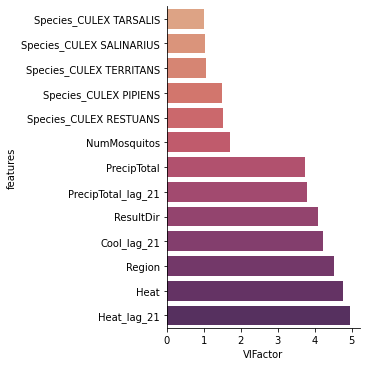

In [14]:
# Visualizing feature importance.

sns.catplot(x='VIFactor', y='features', data=final_vif, kind='bar', orient='h',
           palette ="flare")

In [15]:
final_df.sort_index(inplace=True)
final_df.head(10)

,NumMosquitos,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Heat,PrecipTotal,ResultDir,Region,Heat_lag_21,Cool_lag_21,PrecipTotal_lag_21
Date,,,,,,,,,,,,,
2007-05-29,1,0,0,0,0,0,0.0,0.00,17.5,7,0.0,12.0,0.00
2007-05-29,1,0,1,0,0,0,0.0,0.00,17.5,3,0.0,12.0,0.00
2007-05-29,1,0,1,0,0,0,0.0,0.00,17.5,4,0.0,12.0,0.00
2007-06-05,3,0,1,0,0,0,7.5,0.14,10.0,6,7.5,0.0,0.14
2007-06-05,1,0,0,0,0,0,7.5,0.14,10.0,7,7.5,0.0,0.14
2007-06-05,1,0,1,0,0,0,7.5,0.14,10.0,7,7.5,0.0,0.14
2007-06-05,1,1,0,0,0,0,7.5,0.14,10.0,2,7.5,0.0,0.14
2007-06-05,1,0,1,0,0,0,7.5,0.14,10.0,5,0.0,12.0,0.00
2007-06-05,1,0,1,0,0,0,7.5,0.14,10.0,5,0.0,12.0,0.00


In [16]:
# As the final pre-processing step, I will subset X_train and X_test on final_df, which 
# shows which columns are of use.

X_train = X_train[final_df.columns]
X_train.columns

Index(['NumMosquitos', 'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Heat', 'PrecipTotal', 'ResultDir', 'Region',
       'Heat_lag_21', 'Cool_lag_21', 'PrecipTotal_lag_21'],
      dtype='object')

In [17]:
X_test = X_test[final_df.columns]
X_test.columns

Index(['NumMosquitos', 'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Heat', 'PrecipTotal', 'ResultDir', 'Region',
       'Heat_lag_21', 'Cool_lag_21', 'PrecipTotal_lag_21'],
      dtype='object')

## Modeling

Now that the data is prepped for modeling, it is time to implement these models. I will be using 4 different models, and determining which is the best fit for predicting the target feature, Wnv_Present. These models will include a random forest model, two logistic regression models, and an XG boost model.

In [21]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [22]:
def model_evaluation(model,params,avg):
    '''Creates model, classification report, and plots the roc curve of the model.'''
    pipe = make_pipeline(StandardScaler(),model)
    model_ran = RandomizedSearchCV(pipe,params,cv=10, n_jobs=-1, scoring = 'roc_auc',random_state = 42)
    model_ran = model_ran.fit(X_train,y_train)
    y_pred = model_ran.predict(X_test)
    y_pred_proba = model_ran.predict_proba(X_test)[:,1]
    f1 = f1_score(y_test, y_pred, average= avg)
    cm = confusion_matrix(y_test, y_pred)
    model_roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print('F1-score: ' , round(f1,4))
    print("Best Score: " , round(model_ran.best_score_,4))
    print("Test ROC AUC:", round(model_roc_auc, 4), '\n')
    print("Best Parameters: " , model_ran.best_params_)
    print("Confusion Matrix: " ,'\n', cm, '\n')
    print("Classsification Report: ",'\n', classification_report(y_test, y_pred))

    y_pred_proba=model_ran.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    plt.figure()
    plt.plot(fpr, tpr, label= 'Model (area = %0.2f)' % model_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

### Fit Random Forest Classifier

F1-score:  0.0
Best Score:  0.85
Test ROC AUC: 0.8372 

Best Parameters:  {'randomforestclassifier__n_estimators': 2000, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__criterion': 'entropy'}
Confusion Matrix:  
 [[1969    0]
 [ 110    0]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1969
           1       0.00      0.00      0.00       110

    accuracy                           0.95      2079
   macro avg       0.47      0.50      0.49      2079
weighted avg       0.90      0.95      0.92      2079



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


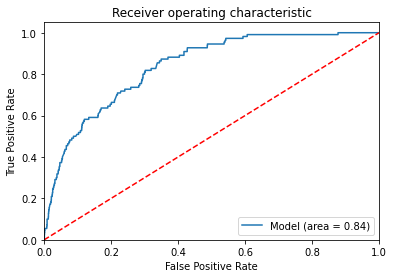

In [25]:
params= {'randomforestclassifier__n_estimators':[500, 600, 800, 1000, 1500, 1800, 2000], 
             'randomforestclassifier__max_features':['auto', 'sqrt', 'log2'], 
             'randomforestclassifier__max_depth':np.arange(4,20), 
             'randomforestclassifier__criterion':['gini', 'entropy'],
            'randomforestclassifier__min_samples_split' : [2, 3, 4] }
avg= 'binary'

model_evaluation(RandomForestClassifier(), params, avg)

### Fit Logistic Regression Classifier

F1-score:  0.0
Best Score:  0.7623
Test ROC AUC: 0.7624 

Best Parameters:  {'logisticregression__penalty': 'l2', 'logisticregression__C': 2.0}
Confusion Matrix:  
 [[1969    0]
 [ 110    0]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1969
           1       0.00      0.00      0.00       110

    accuracy                           0.95      2079
   macro avg       0.47      0.50      0.49      2079
weighted avg       0.90      0.95      0.92      2079



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


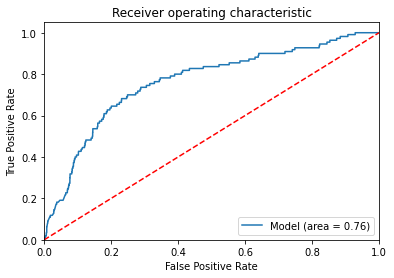

In [26]:
# First logistic regression model

logit1_params = {'logisticregression__penalty':['l1','l2','elasticnet'], 
                'logisticregression__C':np.arange(0.5, 100.0, 0.5) }

logit1 = LogisticRegression()
model_evaluation(logit1, logit1_params, avg)

F1-score:  0.2293
Best Score:  0.769
Test ROC AUC: 0.7651 

Best Parameters:  {'logisticregression__penalty': 'l2', 'logisticregression__class_weight': 'balanced', 'logisticregression__C': 2.0}
Confusion Matrix:  
 [[1469  500]
 [  31   79]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.98      0.75      0.85      1969
           1       0.14      0.72      0.23       110

    accuracy                           0.74      2079
   macro avg       0.56      0.73      0.54      2079
weighted avg       0.93      0.74      0.81      2079



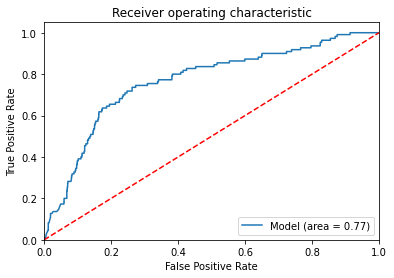

In [27]:
# Second logistic regression model

logit2_params = {'logisticregression__penalty':['l1','l2','elasticnet'], 
                 'logisticregression__class_weight':['balanced'], 
                'logisticregression__C':np.arange(0.5, 100.0, 0.5)}
logit2 = LogisticRegression()

model_evaluation(logit2, logit2_params, avg)

Better than first model.

### Fit XG Boost Classifier

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:30] WARNING: /private/var/folders/rg/vb03dfw167593y158dqrs8200000gn/T/pip-install-h2anl8uv/xgboost/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:59:30] WARNING: /private/var/folders/rg/vb03dfw167593y158dqrs8200000gn/T/pip-install-h2anl8uv/xgboost/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1-score:  0.0678
Best Score:  0.8621
Test ROC AUC: 0.8554 

Best Parameters:  {'xgbclassifier__subsample': 0.89, 'xgbclassifier__silent': 1, 'xgbclassifier__seed': 27, '

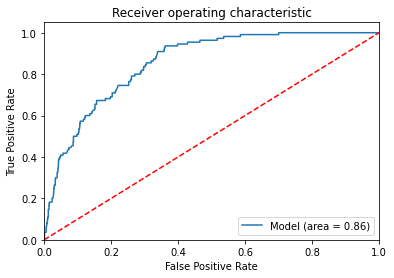

In [28]:
from xgboost import XGBClassifier


xg_params= {'xgbclassifier__nthread':[10], # when use hyperthread, xgboost may become slower
              'xgbclassifier__objective':['binary:logistic'],
              'xgbclassifier__learning_rate':[0.05], # so called `eta` value
              'xgbclassifier__max_depth':[2],
              'xgbclassifier__min_child_weight':[1],
              'xgbclassifier__silent':[1],
              'xgbclassifier__subsample':[.89,.91,.895],
              'xgbclassifier__colsample_bytree':[.58,.585],
              'xgbclassifier__n_estimators':[1000],
             'xgbclassifier__seed':[27]} # number of trees

xgb = XGBClassifier()

model_evaluation(XGBClassifier(), xg_params, avg)

The XG Boost model preformed the best, with the highest auc of 0.86. I will now use shap analysis to explain the model, but first I must fit the model outside of the function it was fit inside of.

[15:59:32] WARNING: /private/var/folders/rg/vb03dfw167593y158dqrs8200000gn/T/pip-install-h2anl8uv/xgboost/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:32] WARNING: /private/var/folders/rg/vb03dfw167593y158dqrs8200000gn/T/pip-install-h2anl8uv/xgboost/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1-score:  0.0678
ROC AUC: 0.8554 

Confusion Matrix:  
 [[1965    4]
 [ 106    4]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1969
           1       0.50      0.04      0.07       110

    accuracy                           0.95      2079
   macro avg       0.72      0.52      0.52      2079
weighted avg       0.93      0.95      0.92      2079



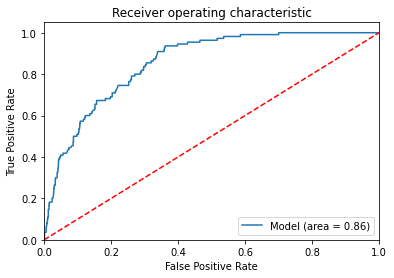

In [29]:
xgb = XGBClassifier(subsample=0.89, 
                   silent=1, 
                   seed=27, 
                   objective= 'binary:logistic', 
                   nthread=10, 
                   n_estimators=1000, 
                   min_child_weight=1, 
                   max_depth=2, 
                   learning_rate=0.05, 
                   colsample_bytree=0.58)

xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:,1]

f1 = f1_score(y_test, y_pred, average= 'binary')
cm = confusion_matrix(y_test, y_pred)
model_roc_auc = roc_auc_score(y_test, y_pred_proba)

print('F1-score: ' , round(f1,4))
print("ROC AUC:", round(model_roc_auc, 4), '\n')
print("Confusion Matrix: " ,'\n', cm, '\n')
print("Classsification Report: ",'\n', classification_report(y_test, y_pred))
y_pred_proba=xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label= 'Model (area = %0.2f)' % model_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

### Variable Importance Plot

In [30]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


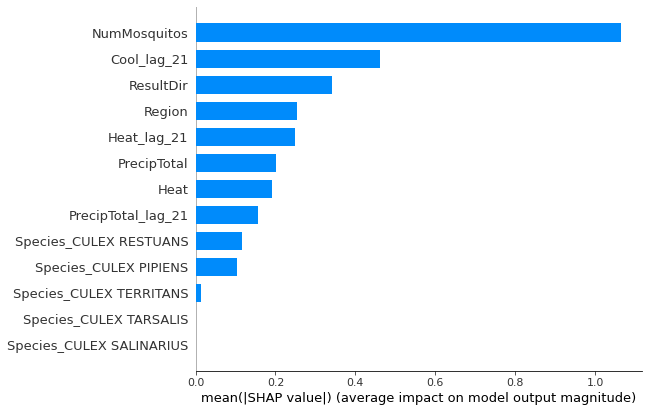

In [31]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Summary Plot

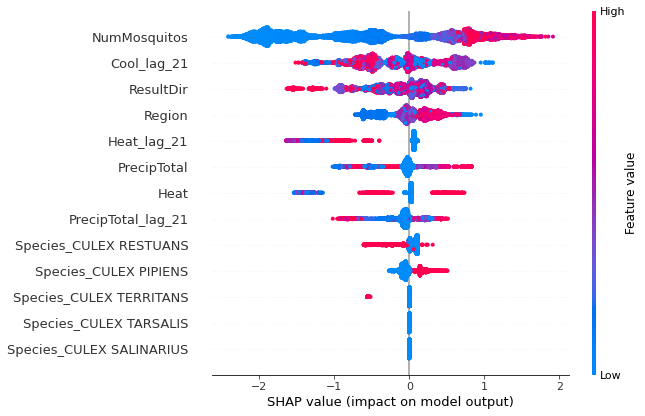

In [32]:
shap.summary_plot(shap_values, X_train)

- **Feature importance**: From top to bottom, features are ranked in order of importance.

- **Impact**: The horizontal position shows whether the effect of the value is associated with a higher or lower prediction.

- **Original value**: Color shows whether that variable is high (in red) or low (in blue) for that observation.

- **Correlation**: A high level of the “NumMosquitos” has a high positive impact on the quality rating, and a low negative, which means the same. The “high” comes from the red color, and the “positive” impact is shown on the x-axis. Similarly, we can say “Species_CULEX RESTUANS” is negatively correlated with the target variable.

### Dependence Plots

The dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic, or more complex.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


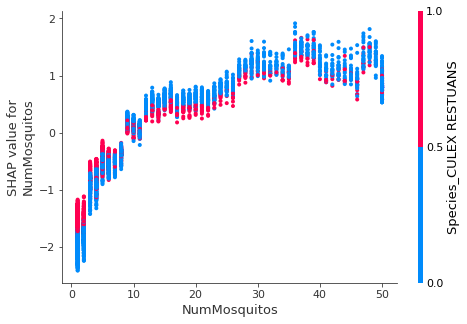

In [33]:
shap.dependence_plot('NumMosquitos', shap_values, X_train)

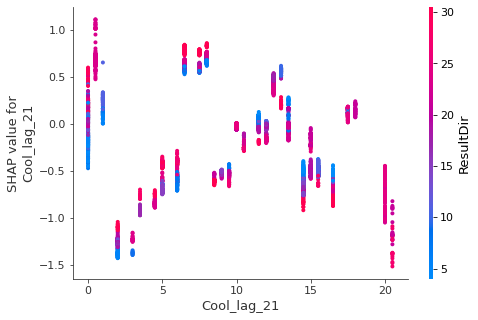

In [34]:
shap.dependence_plot('Cool_lag_21', shap_values, X_train)

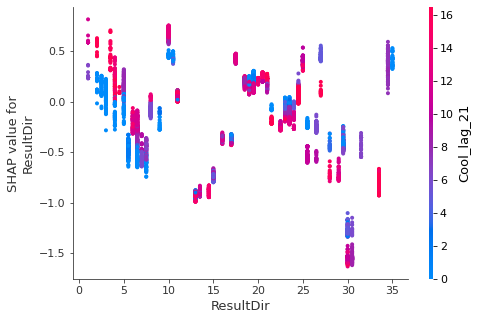

In [35]:
shap.dependence_plot('ResultDir', shap_values, X_train)

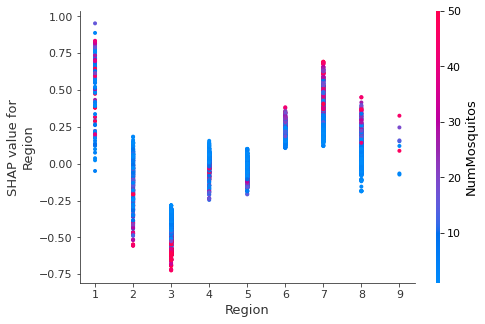

In [36]:
shap.dependence_plot('Region', shap_values, X_train)

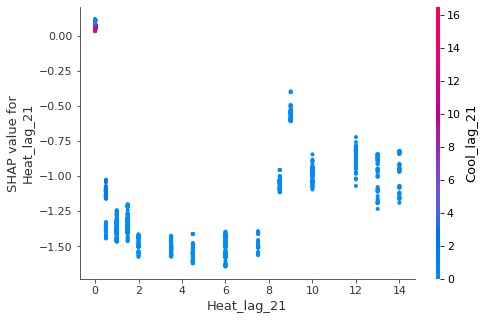

In [37]:
shap.dependence_plot('Heat_lag_21', shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


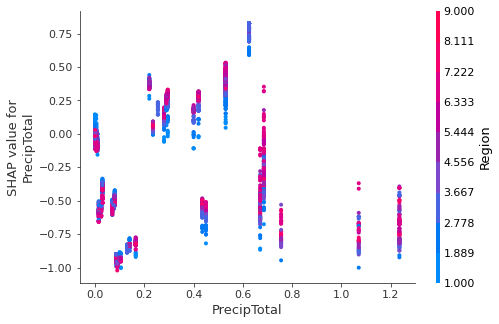

In [38]:
shap.dependence_plot('PrecipTotal', shap_values, X_train)

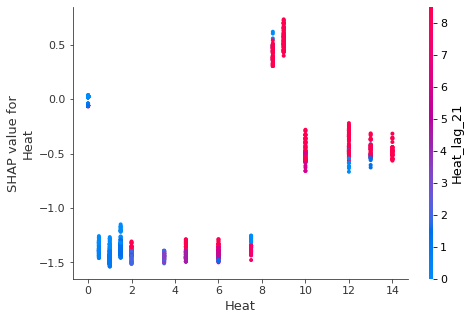

In [39]:
shap.dependence_plot('Heat', shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


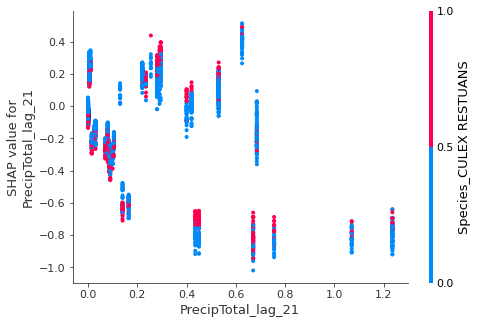

In [40]:
shap.dependence_plot('PrecipTotal_lag_21', shap_values, X_train)

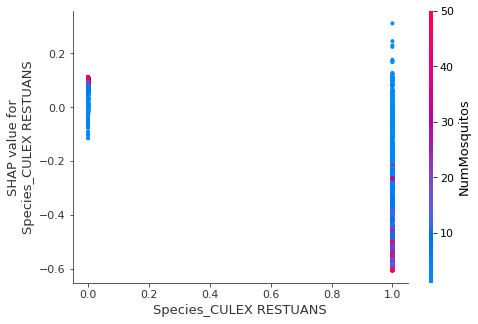

In [41]:
shap.dependence_plot('Species_CULEX RESTUANS', shap_values, X_train)

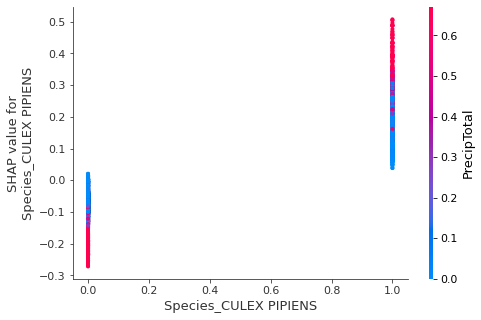

In [42]:
shap.dependence_plot('Species_CULEX PIPIENS', shap_values, X_train)

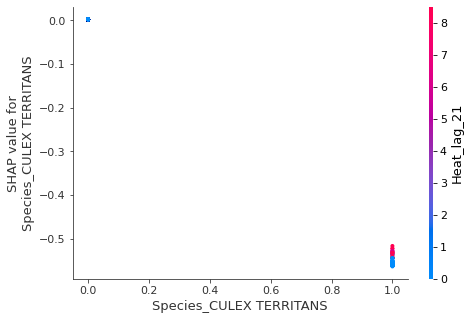

In [43]:
shap.dependence_plot('Species_CULEX TERRITANS', shap_values, X_train)

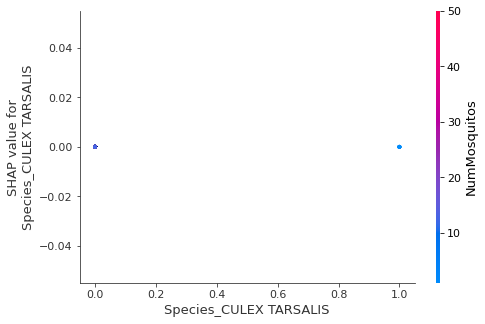

In [44]:
shap.dependence_plot('Species_CULEX TARSALIS', shap_values, X_train)

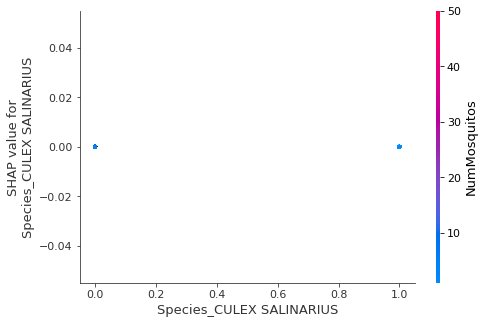

In [45]:
shap.dependence_plot('Species_CULEX SALINARIUS', shap_values, X_train)